In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer,mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df = pd.read_csv("final.csv")

## Analiz dosyasından elde ettiğim bilgilerle dropladıgım index'ler ve kolonlar

In [125]:
# Kolon sırasını standartlaştır (önce yıl ve ülke kodları)
df = df[["year", "iso_code"] + [col for col in df.columns if col not in ["year", "iso_code"]]]

# Karışıklık yaratan kolon adları yeniden isimlendirildi
df.rename(columns={
    "country_x": "country",
    "co2_per_capita_y": "co2_per_capita",
    "cumulative_co2_y": "cumulative_co2"
}, inplace=True)

# Aşırı eksik veriye sahip küçük ülkeler analiz dışı bırakıldı
df = df[~df["country"].isin(["Andorra", "Liechtenstein", "Monaco", "Saint Kitts and Nevis", "San Marino"])]

# Korelasyonu zayıf, model için anlamlı katkı sunmayan kolonlar çıkarıldı
df.drop(["energy_per_capita", "other_renewables_share_elec", "infrastructure", "capacity"], axis=1, inplace=True)

# 2023 yılına ait verilerde bozukluk gözlemlendiği için hariç tutuldu
df = df[df["year"] != 2023]

## BOŞ DEĞERLERİN DOLDURULMASI

In [127]:
df.isnull().sum()

year                  0
iso_code              0
gain                  0
readiness             0
vulnerability         0
economic            140
governance           84
health               28
exposure              0
ecosystems          196
habitat               0
sensitivity         168
country               0
co2_per_capita        0
cumulative_co2        0
share_global_co2      0
person_gdp          728
population            0
dtype: int64

## "person_gdp" XGBoost Tahminleriyle Doldurma

Fitting 3 folds for each of 32 candidates, totalling 96 fits
MAE:  834.88
RMSE: 1384.20
R²:   0.9933


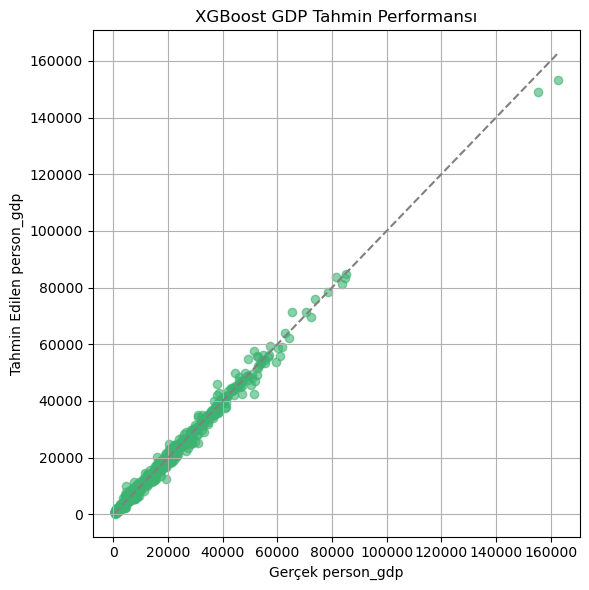

In [129]:
# Eksik olmayan GDP verilerini filtrele
df_notna = df[df["person_gdp"].notna()]

# Girdi–çıktı değişkenlerini ayır
X = df_notna.drop(columns=["person_gdp", "country", "iso_code"])
y = df_notna["person_gdp"]

# Eğitim ve test setine ayır
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# XGBoost modeli ve hiperparametre arama
model = XGBRegressor(objective="reg:squarederror", random_state=2)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

# En iyi model ve tahminler
best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

# Model performansı
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Tahmin – Gerçek Değer Karşılaştırması Grafiği
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.6, color="mediumseagreen")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "--", color="gray")
plt.xlabel("Gerçek person_gdp")
plt.ylabel("Tahmin Edilen person_gdp")
plt.title("XGBoost GDP Tahmin Performansı")
plt.grid(True)
plt.tight_layout()
plt.show()

#### "person_gdp" değerlerini atama

In [131]:
# 1. Eksik person_gdp satırlarını ayır
df_missing = df[df["person_gdp"].isna()].copy()

# 2. Modelin kullandığı aynı sütunları al
X_missing = df_missing.drop(columns=["person_gdp", "country", "iso_code"])

# 3. Eksik satırlar için tahmin yap
predicted_values = best_model.predict(X_missing)

# 4. Tahmin edilen person_gdp değerlerini df'ye geri yaz
df.loc[df["person_gdp"].isna(), "person_gdp"] = predicted_values

## Readiness Bileşenlerinde Eksik Verilerin Modelle Tamamlanması

In [133]:
def evaluate_regression_model(df, target, features, model_label="Model"):
    df_train = df[df[target].notnull() & df[features].notnull().all(axis=1)]
    X_train, y_train = df_train[features], df_train[target]
    df_missing = df[df[target].isnull() & df[features].notnull().all(axis=1)]

    model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)

    print(f"\nHedef değişken: {target}")
    print(f"Açıklayıcı değişkenler: {features}")
    print(f"R2 skoru: {r2:.3f}")
    print(f"Ortalama hata (MAE): {mae:.4f}")

    importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    print(f"\n{model_label} - Özellik katkı düzeyleri:")
    print(importance)

    if not df_missing.empty:
        df.loc[df_missing.index, target] = model.predict(df_missing[features])
        print(f"Tahmin edilen '{target}' satırı: {len(df_missing)}")
    else:
        print(f"'{target}' için tahmin yapılacak satır yok.")

# Sırasıyla modelleri çalıştır
evaluate_regression_model(
    df,
    target="health",
    features=["vulnerability", "sensitivity", "exposure", "habitat", "ecosystems"],
    model_label="health Model"
)

evaluate_regression_model(
    df,
    target="governance",
    features=["vulnerability", "sensitivity", "exposure", "habitat", "ecosystems"],
    model_label="Health Model"
)

evaluate_regression_model(
    df,
    target="economic",
    features=["readiness", "gain", "person_gdp"],
    model_label="economic Model"
)

evaluate_regression_model(
    df,
    target="sensitivity",
    features=["economic", "readiness", "gain", "person_gdp", "health"],
    model_label="Governance Model"
)

evaluate_regression_model(
    df,
    target="ecosystems",
    features=["vulnerability", "sensitivity", "exposure", "habitat", "health"],
    model_label="Ecosystems Model"
)


Hedef değişken: health
Açıklayıcı değişkenler: ['vulnerability', 'sensitivity', 'exposure', 'habitat', 'ecosystems']
R2 skoru: 0.980
Ortalama hata (MAE): 0.0179

health Model - Özellik katkı düzeyleri:
vulnerability    0.855297
exposure         0.048395
habitat          0.034321
sensitivity      0.031603
ecosystems       0.030384
dtype: float32
Tahmin edilen 'health' satırı: 28

Hedef değişken: governance
Açıklayıcı değişkenler: ['vulnerability', 'sensitivity', 'exposure', 'habitat', 'ecosystems']
R2 skoru: 0.937
Ortalama hata (MAE): 0.0436

Health Model - Özellik katkı düzeyleri:
vulnerability    0.459698
ecosystems       0.159186
habitat          0.153997
exposure         0.134845
sensitivity      0.092274
dtype: float32
Tahmin edilen 'governance' satırı: 84

Hedef değişken: economic
Açıklayıcı değişkenler: ['readiness', 'gain', 'person_gdp']
R2 skoru: 0.805
Ortalama hata (MAE): 0.0436

economic Model - Özellik katkı düzeyleri:
readiness     0.840715
person_gdp    0.098993
gain     

## Log Dönüşüm

In [135]:
columns_to_log = ["cumulative_co2", "person_gdp", "population"]

# Negatif veya sıfır varsa log1p kullanmak en güvenlisidir
for col in columns_to_log:
    df[f"{col}_log"] = np.log1p(df[col])  # log(1 + x)

In [136]:
df.head()

,year,iso_code,gain,readiness,vulnerability,economic,governance,health,exposure,ecosystems,habitat,sensitivity,country,co2_per_capita,cumulative_co2,share_global_co2,person_gdp,population,cumulative_co2_log,person_gdp_log,population_log
0,1995,AFG,34.783530,0.308182,0.612511,0.496497,0.128090,0.748302,0.480512,0.515884,0.602933,0.419587,Afghanistan,0.083,66.358,0.006,721.179181,17065836.0,4.210022,6.582273,16.652589
1,1996,AFG,34.775074,0.308181,0.612679,0.496497,0.128090,0.748302,0.480512,0.516995,0.604235,0.419307,Afghanistan,0.077,67.728,0.006,679.499268,17763265.0,4.230157,6.522827,16.692643
2,1997,AFG,34.988812,0.312614,0.612837,0.496497,0.141392,0.748302,0.480512,0.518030,0.605583,0.419055,Afghanistan,0.071,69.032,0.005,642.244136,18452100.0,4.248952,6.466524,16.730689
3,1998,AFG,35.293407,0.317047,0.611179,0.496497,0.154694,0.748302,0.480512,0.518156,0.606909,0.418794,Afghanistan,0.067,70.311,0.005,610.238711,19159996.0,4.267051,6.415488,16.768335
4,1999,AFG,35.177507,0.313378,0.609828,0.496497,0.143689,0.748302,0.480512,0.518156,0.608137,0.419433,Afghanistan,0.055,71.402,0.004,579.114900,19887791.0,4.282234,6.363226,16.805617


## Linear Model

5-Fold CV RMSE ortalama: 0.06326100894268491
5-Fold CV R² ortalama: 0.8067963368294105


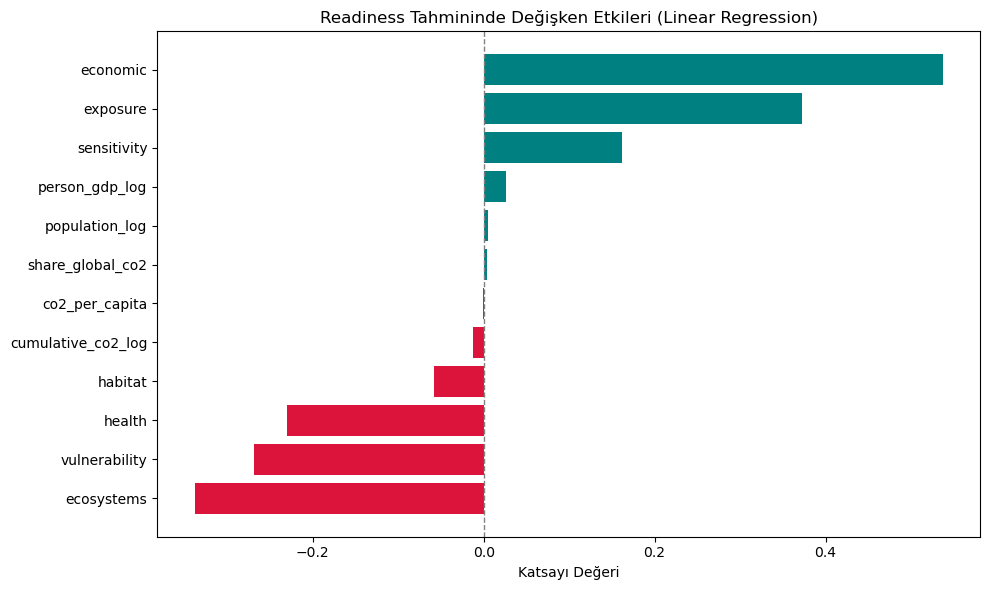

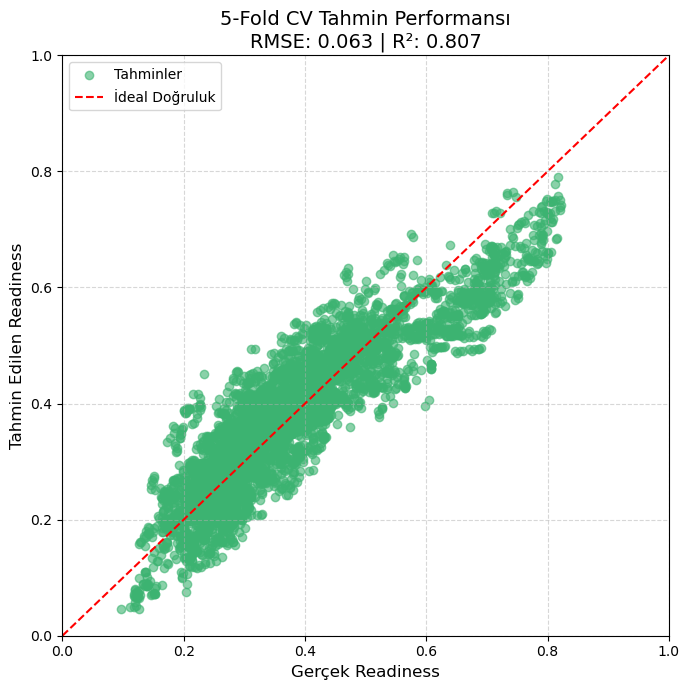

In [138]:
# Özellik seçimleri (log dönüşüm uygulanmış değişkenler dahil)
features = [col for col in df.columns if col not in [
    "gain", "readiness", "country", "iso_code", "year", "governance",
    "cumulative_co2", "person_gdp", "population"  # log öncesi versiyonlar hariç
]]

X = df[features].values
y = df["readiness"].values

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []
y_tests = []
y_preds = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)
    y_tests.extend(y_test)
    y_preds.extend(y_pred)

print("5-Fold CV RMSE ortalama:", np.mean(rmse_list))
print("5-Fold CV R² ortalama:", np.mean(r2_list))

# Tüm veriyle final model
final_model = LinearRegression()
final_model.fit(X, y)

# Katsayılar görselleştirmesi
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": final_model.coef_
}).sort_values(by="Coefficient", ascending=True)

plt.figure(figsize=(10, 6))
colors = ["crimson" if coef < 0 else "teal" for coef in coef_df["Coefficient"]]
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color=colors)
plt.axvline(x=0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Katsayı Değeri")
plt.title("Readiness Tahmininde Değişken Etkileri (Linear Regression)")
plt.tight_layout()
plt.show()

# Tahmin performansı: gerçek vs tahmin
plt.figure(figsize=(7, 7))
plt.scatter(y_tests, y_preds, alpha=0.6, color='mediumseagreen', label='Tahminler')
plt.plot([0, 1], [0, 1], 'r--', label='İdeal Doğruluk')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Gerçek Readiness', fontsize=12)
plt.ylabel('Tahmin Edilen Readiness', fontsize=12)
plt.title(f'5-Fold CV Tahmin Performansı\nRMSE: {np.mean(rmse_list):.3f} | R²: {np.mean(r2_list):.3f}', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## XGBoost Model

Cross-Validated R² Scores: [0.90232124 0.86443102 0.83115368 0.8574423  0.82166305]
Mean R² Score (CV): 0.8554
RMSE: 0.0150
R² Score (Test Set): 0.9892


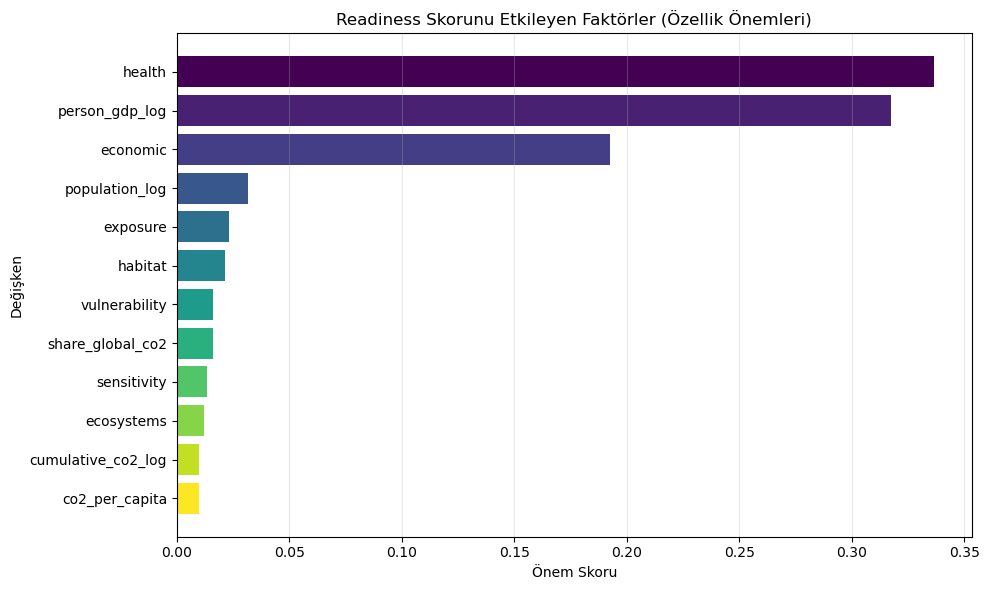

In [140]:
# Özellik ve hedef ayrımı
drop_cols = ["readiness", "iso_code", "country", "year", "gain", "governance", "cumulatii,,.ve_co2", "person_gdp", "population"]
X = df.drop(columns=drop_cols)
y = df["readiness"]

# Eğitim ve test verisi bölünmesi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model oluşturma
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Cross-validation (5 katlı)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validated R² Scores: {cv_scores}")
print(f"Mean R² Score (CV): {cv_scores.mean():.4f}")

# Modeli eğit
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metrikleri
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {mse ** 0.5:.4f}")
print(f"R² Score (Test Set): {r2:.4f}")

# Özellik Önemleri Analizi

importances = model.feature_importances_
features = X.columns

df_importances = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))

# Viridis renk skalasını özellik sayısına göre al
colors = plt.cm.viridis(np.linspace(0, 1, len(df_importances)))

plt.barh(df_importances["feature"], df_importances["importance"], color=colors)
plt.xlabel("Önem Skoru")
plt.ylabel("Değişken")
plt.title("Readiness Skorunu Etkileyen Faktörler (Özellik Önemleri)")
plt.gca().invert_yaxis()  # En yüksek en üstte olsun
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

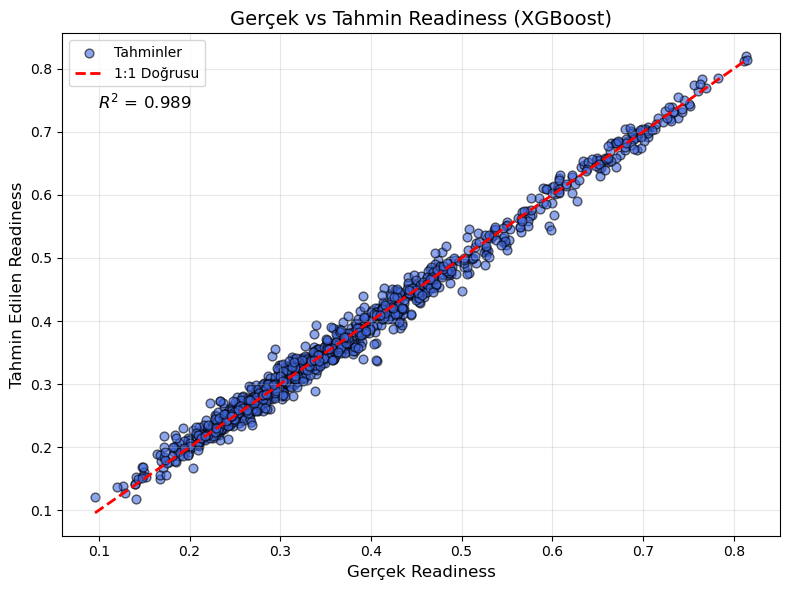

In [141]:
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue', edgecolors='k', s=40, label='Tahminler')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='1:1 Doğrusu')

plt.title("Gerçek vs Tahmin Readiness (XGBoost)", fontsize=14)
plt.xlabel("Gerçek Readiness", fontsize=12)
plt.ylabel("Tahmin Edilen Readiness", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.text(0.05, 0.85, f"$R^2$ = {r2:.3f}", fontsize=12, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [142]:
df_compare = pd.DataFrame({
    "Gerçek Readiness": y_test[:10].values,
    "Tahmin Edilen Readiness": y_pred[:10]
})

print(df_compare.round(4))  # Virgülden sonra 4 basamak göster

   Gerçek Readiness  Tahmin Edilen Readiness
0            0.4131                   0.4137
1            0.5625                   0.5636
2            0.3811                   0.3581
3            0.4150                   0.4169
4            0.6314                   0.6445
5            0.3614                   0.3525
6            0.4319                   0.4051
7            0.4414                   0.4508
8            0.6013                   0.5686
9            0.1854                   0.1763


## Kapanış: Hazır Olanlar, Sorumlu Olanlar, Geride Kalanlar

### Çalışmam boyunca şunu sordum: İklim krizine kim hazır, ama aynı zamanda bu krizi kim yarattı? 
### Son görselim, bu çarpıcı tabloyu özetliyor.


![Climate Justice Triangle](image.png)

## Kapanış – Çözüm Kolektifse Umut da Gerçek

Bu proje yalnızca bir analiz değil, aynı zamanda bir farkındalık çağrısıydı. Veriler gösteriyor ki, iklim krizinde hem sorumluluk hem de kırılganlık eşit dağılmıyor. Ben de bu tabloyu görünür kılarak şunu öneriyorum:

Veriyi daha şeffaf paylaşalım

Hazırlık kapasitesini daha adil biçimde destekleyelim

İyi örnekleri birlikte çoğaltalım

Çünkü kriz hepimizi ilgilendiriyor çözüm de birlikte mümkün.